In [9]:
import os
import sys
import lief
import time
import struct
import numpy as np
import pickle
import threading
import subprocess
from tqdm import tqdm
from multiprocessing import Manager, Pool

In [10]:
from raw_features import ByteHistogram, ByteEntropyHistogram, PEFeatureExtractor
from feature_engineering import Feature_engineering

In [174]:
if len(sys.argv) > 1:
    datapath = sys.argv[1]
else:
    datapath = "../dataset/test"
datapath = "../dataset/datacon_miner"
datapath = "../dataset/test"


black_path = []
black_list = []
for parent, dirnames, filenames in os.walk(datapath):
    if "/miner" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            black_path.append(fp)
            black_list.append(filename)
white_path = []
white_list = []
for parent, dirnames, filenames in os.walk(datapath):
    if "/not_miner" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            white_path.append(fp)
            white_list.append(filename)
            
print("Found {0} miner samples.".format(len(black_path)))
print("Found {0} not miner samples.".format(len(white_path)))

test_path = []
for parent, dirnames, filenames in os.walk(datapath):
    for filename in filenames:
        fp = os.path.join(parent, filename)
        test_path.append(fp)

hash_list = [os.path.split(sp)[-1] for sp in test_path]
test_fixed_path = [os.path.join("../tmp", sp) for sp in hash_list]

test_num = len(test_fixed_path)
print("Found {0} samples in total.".format(test_num))

with open("../models/hash_list.pkl", "wb") as f:
    pickle.dump(hash_list, f)
    
emp = threading.Semaphore(value=12)

Found 10 miner samples.
Found 10 not miner samples.
Found 20 samples in total.


In [41]:
test_path

['../dataset/test/miner/00a8b0ff6c1a48a69f85657e57d9ed99',
 '../dataset/test/miner/00aaa7dbbd6cf67691a84ea2070fb80a',
 '../dataset/test/miner/00aebe8df3665fd3c9bffb27ed96091b',
 '../dataset/test/miner/00b4d53492887224c5ec460baa0c27c8',
 '../dataset/test/miner/00c0a0f05261d54d4d8d806b4ba888ee',
 '../dataset/test/miner/00ccce26144cb59a8b308c4ba1d5537a',
 '../dataset/test/miner/0a03d7673610d7f8c689213c483d885d',
 '../dataset/test/miner/0a1d16db82b4fc57a99e05f39e915daf',
 '../dataset/test/miner/0a2e1a50b710e21f3d501bde2cea7c9a',
 '../dataset/test/miner/0a4e987dc1c8641dfb7e69de460398d2',
 '../dataset/test/not_miner/000a8c7ef0700888b67c38e08c9cd245',
 '../dataset/test/not_miner/000af59aaf025c9b18dc8f94c45cb381',
 '../dataset/test/not_miner/000cbfd14958df9314a49953129a6ce6',
 '../dataset/test/not_miner/00a0f24620e0227126a062a2d5fba373',
 '../dataset/test/not_miner/00a8869cc1be6a443b4d05e1eaed86a9',
 '../dataset/test/not_miner/00a972a6b45f757a79fe26a01bc4a46d',
 '../dataset/test/not_miner/00ad

In [175]:
pe = PEFeatureExtractor()

In [176]:
fn = Feature_engineering()

In [177]:
def fix_header(fp, ha):
    with open(fp, 'rb') as f:
        data = f.read()
    e_lfnew = data[0x3C: 0x40]
    offset = int.from_bytes(e_lfnew, byteorder='little', signed=True)
    new_data = b"MZ" + data[2:offset] + b"PE\0\0" + data[offset+4:]

    new_path = "../tmp/{0}".format(ha)
    with open(new_path, 'wb') as f:
        f.write(new_data)
    emp.release()

# ---------------------直方图------------------------

def histogram_feature(sample_path):
    with open(sample_path, "rb") as f:
        data = f.read()
    file_size = len(data)
    Histogram = ByteHistogram().raw_features(data, None)
    Byte_Entropy = ByteEntropyHistogram().raw_features(data, None)

    Sum = 0
    for i in range(len(Byte_Entropy)):
        Sum += Byte_Entropy[i]

    Histogram = np.array(Histogram) / file_size
    Byte_Entropy = np.array(Byte_Entropy) / Sum

    feature = np.concatenate((Histogram, Byte_Entropy), axis=-1)
    feature = list(feature)
    path = sample_path.replace("tmp", "histogram") + ".txt"
    with open(path, 'w') as f:
        for i in feature:
            f.write("{}\n".format(str(i)))


# ---------------------PE静态特征------------------------

pe_raw_vectors = Manager().list([0] * test_num)

def get_pe_raw_vector(idx, fp, res_default):
    res = res_default
    try:
        with open(fp, 'rb') as f:
            raw_data = f.read()
        res = pe.feature_vector(raw_data)
    except Exception:
        pass
    pe_raw_vectors[idx] = res


# ---------------------特征工程------------------------

feature_engineering_features = Manager().list([0] * test_num)

def get_fn(idx, fp):
    with open(fp, 'rb') as f:
        data = f.read()
    res = fn.get_feature_engineering(data)
    feature_engineering_features[idx] = res

In [178]:
pe_raw_vectors = Manager().list([0] * test_num)   # PE静态特征

In [179]:
feature_engineering_features = Manager().list([0] * test_num)   # 特征工程

In [69]:
# black_path = []
# for parent, dirnames, filenames in os.walk(datapath):
#     if "/miner" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             black_path.append(fp)
# white_path = []
# for parent, dirnames, filenames in os.walk(datapath):
#     if "/not_miner" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             white_path.append(fp)

In [ ]:
# 单独测试用的数据集
# datapath = "../dataset/datacon_miner"
# black_path = []
# for parent, dirnames, filenames in os.walk(datapath):
#     if "/miner" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             black_path.append(fp)
# white_path = []
# for parent, dirnames, filenames in os.walk(datapath):
#     if "/not_miner" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             white_path.append(fp)
# print("Found {0} miner samples.".format(len(black_path)))
# print("Found {0} not miner samples.".format(len(white_path)))

In [180]:
    # 修复MZ和PE头
    print("Preprecess started.")
    os.system("rm -rf ../tmp")
    os.makedirs("../tmp")
    table = []
    with tqdm(total=test_num, ncols=80, desc="fix") as pbar:
        for fp, ha in zip(test_path, hash_list):
            emp.acquire()
            t = threading.Thread(target=fix_header, args=(fp, ha), daemon=True)
            t.start()
            table.append(t)
            pbar.update(1)
    for t in table:
        t.join()

Preprecess started.


fix: 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 126.09it/s]


In [316]:
    # 直方图
    os.system("rm -rf ../histogram")
    os.makedirs("../histogram")
    start_time = time.time()
    with Pool(12) as pool:
        for fp in test_fixed_path:
            pool.apply_async(func=histogram_feature, args=(fp, ))
        pool.close()
        pool.join()
    end_time = time.time()
    print("hostogram: {0:.2f}s".format(end_time - start_time))
    start_time = end_time

hostogram: 0.49s


In [182]:
    # PE静态特征
    os.system("rm -rf ../pe_raw")
    os.makedirs("../pe_raw")
    res_default = np.zeros(shape=(967,), dtype=np.float32)
    with Pool(12) as pool:
        for i, fp in enumerate(test_fixed_path):
            pool.apply_async(func=get_pe_raw_vector, args=(i, fp, res_default))
        pool.close()
        pool.join()
    with open("../pe_raw/pe_raw_vectors.pkl", "wb") as f:
        pickle.dump(list(pe_raw_vectors), f)
    end_time = time.time()
    print("pe raw: {0:.2f}s".format(end_time - start_time))
    start_time = end_time

pe raw: 2.56s


In [184]:
    # 特征工程
    os.system("rm -rf ../feature_engineering")
    os.makedirs("../feature_engineering")
    with Pool(12) as pool:
        for i, fp in enumerate(test_fixed_path):
            pool.apply_async(func=get_fn, args=(i, fp))
        pool.close()
        pool.join()
    end_time = time.time()
    print("feature engineering: {0:.2f}s".format(end_time - start_time))

    with open("../feature_engineering/feature_engineering_features.pkl", 'wb') as f:
        pickle.dump(list(feature_engineering_features), f)

    print("Preprecess done.")

feature engineering: 5.18s
Preprecess done.


# Model Create

In [ ]:
# first do pe raw feature extract

In [250]:
import os
import time
import numpy as np
import pandas as pd
import pickle
from multiprocessing import Manager, Pool

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

with open("../models/hash_list.pkl", "rb") as f:
    hash_list = pickle.load(f)

In [338]:
# ---------------------直方图------------------------
start_time = time.time()
print("Histogram predict: {0:.2f}s".format(time.time()-start_time))
test_path = [os.path.join("../histogram", sp) for sp in hash_list]
test_num = len(test_path)
raw_feature = np.empty((test_num, 512))
for i, fp in enumerate(test_path):
    with open(fp+'.txt', 'r') as f:
        feature = f.readlines()
    feature = [float(his.strip()) for his in feature]
    raw_feature[i] = feature
model = tf.keras.models.load_model('../models/histogram_0.50.h5')
histogram_test = model.predict(raw_feature)

Histogram predict: 0.00s


In [298]:
# ---------------------PE静态特征------------------------
print("PE raw predict: {0:.2f}s".format(time.time()-start_time))
start_time = time.time()
with open("../models/raw_feature.pkl", "rb") as fp:
    pe_raw_models = pickle.load(fp)

with open("../models/raw_feature_names.pkl", "rb") as fp:
    raw_feature_names = pickle.load(fp)

with open("../models/rfc_pe_model.pkl", "rb") as f:
    rfc_pe_model = pickle.load(f)

with open("../pe_raw/pe_raw_vectors.pkl", "rb") as f:
    pe_raw_vectors = pickle.load(f)

PE raw predict: 1179.75s


In [299]:
n_splits = 5
pe_raw_vectors = np.array(pe_raw_vectors, dtype=np.float32)

oof_test_skf = Manager().list([0] * n_splits) # np.empty((n_splits, test_num))
def pe_raw_predict(ind, model):
    oof_test_skf[ind] = model.predict(pe_raw_vectors)

In [288]:
raw_feature_names

['lr', 'gbc', 'bc', 'xgb', 'dt', 'svm', 'rfc', 'etc', 'ada']

In [300]:
raw_feature_names = ['lr', 'gbc', 'bc']

In [310]:
stacking_test = []
for name in raw_feature_names:
    pool = Pool(5)
    for i, model in enumerate(pe_raw_models[name]):
        pool.apply_async(func=pe_raw_predict, args=(i, model))
    pool.close()
    pool.join()
    oof_test = np.array(list(oof_test_skf), dtype=np.float32).mean(axis=0)
    stacking_test.append(oof_test.reshape(-1, 1))
stacking_test = np.hstack(stacking_test)
raw_feature_test = rfc_pe_model.predict(stacking_test).reshape(-1, 1)

In [341]:
features, labels = np.array(raw_feature, dtype=np.float32), np.array(raw_labels, dtype=np.int32)
model = tf.keras.models.load_model('../models/histogram_0.50.h5')

In [342]:
histogram_train = model.predict(features)

In [343]:
sum([1 for i in histogram_train if i >= 0.5])

6

In [ ]:
# 融合

In [344]:
train = np.hstack([histogram_train , raw_feature_train])
#train = np.hstack([feature_engineerin_train, histogram_train , raw_feature_train])

In [345]:
stacking_train_5 = train

train_data, test_data, train_labels, test_labels = train_test_split(stacking_train_5,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=2020) # 0x4651

In [346]:
lr_model = LogisticRegression(random_state=7)
lr_model.fit(train_data, train_labels)
train_pre_lr = lr_model.predict(train_data)
y_pred_lr = lr_model.predict(test_data)

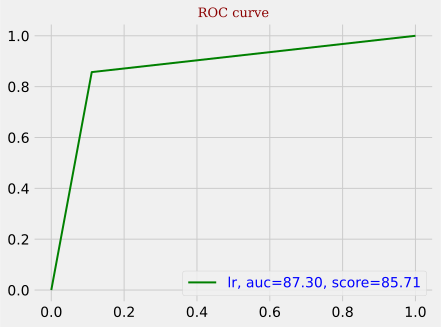

In [347]:
plot(train_labels, train_pre_lr, "lr")

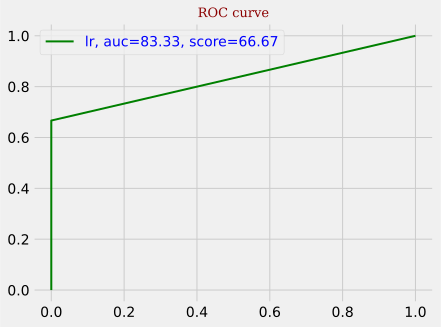

In [348]:
plot(test_labels, y_pred_lr, "lr")

In [349]:
params = {'num_leaves': 8, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 1,
          'objective': 'binary', #定义的目标函数
          'max_depth': 3,
          'learning_rate': 0.01,
          "min_sum_hessian_in_leaf": 8,
          "boosting": "gbdt",
          "feature_fraction": 0.9,	#提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,				#l1正则
          # 'lambda_l2': 0.001,		#l2正则
          "verbosity": -1,
          "nthread": -1,				#线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss'},	##评价函数选择
          "random_state": 5555,	#随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
}
trn_data = lgb.Dataset(train_data, label=train_labels)
val_data = lgb.Dataset(test_data, label=test_labels)
clf = lgb.train(params, trn_data, 1000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds=20)
train_pred_lgb = clf.predict(train_data)
train_pred_lgb_b = np.where(train_pred_lgb < 0.5, 0, 1)

y_pred_lgb = clf.predict(test_data)
y_pred_lgb_b = np.where(y_pred_lgb < 0.5, 0, 1)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.692985	valid_1's binary_logloss: 0.850057


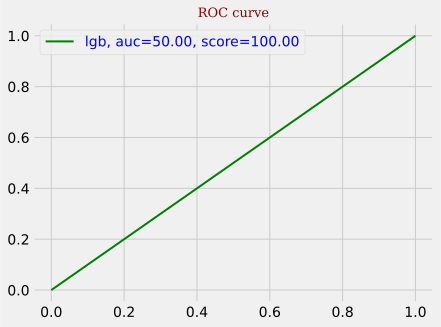

In [350]:
plot(train_labels, train_pred_lgb_b, "lgb")

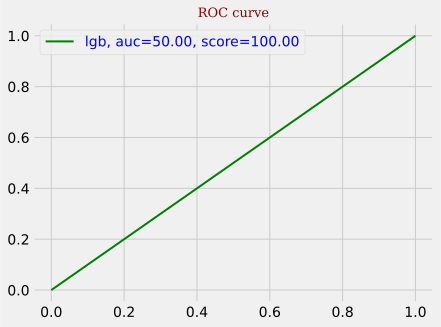

In [351]:
plot(test_labels, y_pred_lgb_b, "lgb")

In [352]:
rfc_model = RandomForestClassifier(100, random_state=7)
rfc_model.fit(train_data, train_labels)
train_pred_rfc = rfc_model.predict(train_data)
y_pred_rfc = rfc_model.predict(test_data)

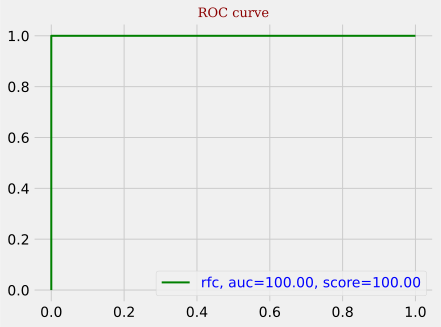

In [353]:
plot(train_labels, train_pred_rfc, "rfc")

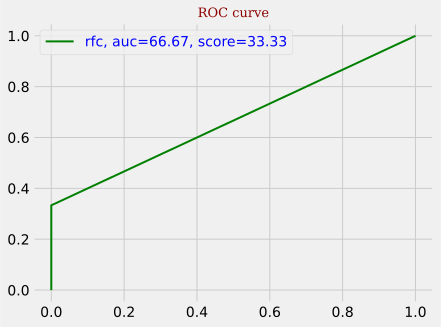

In [354]:
plot(test_labels, y_pred_rfc, "rfc")

In [355]:
labels_lr = lr_model.predict_proba(train)
labels_rfc = rfc_model.predict_proba(train)


labels_lgb = clf.predict(stacking_train_5)
train_labels = []
for x, y in zip(labels_lr, labels_rfc):
    if x[1]*0.3 + y[1]*0.7 < 0.5:
        train_labels.append(0)
    else:
        train_labels.append(1)

In [356]:
sum(train_labels)

8

In [358]:
accs = accuracy_score(labels, train_labels)
fpr, tpr, _ = metrics.roc_curve(labels, train_labels)
auc = metrics.roc_auc_score(labels, train_labels)
score = tpr[1] - 1.2*fpr[0]
accs, auc, score

(0.9, 0.9, 0.8)

In [360]:
with open("../models/lr_rfc.pkl", "wb") as f:
    pickle.dump([lr_model, rfc_model], f)

In [362]:
# ---------------------融合------------------------

print("Final predict: {0:.2f}s".format(time.time()-start_time))
start_time = time.time()
with open("../models/lr_rfc.pkl", "rb") as f:
    lr_rfc = pickle.load(f)

test = np.hstack([histogram_test , raw_feature_test])
#test = np.hstack([feature_engineerin_test, histogram_test , raw_feature_test])

labels_lr = lr_rfc[0].predict_proba(test)
labels_rfc = lr_rfc[1].predict_proba(test)

test_labels = []

for x, y in zip(labels_lr, labels_rfc):
    if x[1]*0.6+ y[1]*0.4  < 0.5:
        test_labels.append(0)
    else:
        test_labels.append(1)

print("Found {0} black samples. {1:.2f}s".format(sum(test_labels), time.time()-start_time))

result = []
for pt, label in zip(hash_list, test_labels):
    result.append("{0}, {1}\n".format(pt, label))
with open("../malware_final.txt", 'w') as f:
    f.write(''.join(result).strip())

Final predict: 17.39s
Found 10 black samples. 0.03s


## pe raw feature extract

In [185]:
import os
import time
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

import lief

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score

from raw_features import PEFeatureExtractor

In [313]:
datapath = "../dataset/datacon_miner"
datapath = "../dataset/test"

black_path = []
black_list = []
for parent, dirnames, filenames in os.walk(datapath):
    if "/miner" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            black_path.append(fp)
            black_list.append(filename)
white_path = []
white_list = []
for parent, dirnames, filenames in os.walk(datapath):
    if "/not_miner" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            white_path.append(fp)
            white_list.append(filename)
            
print("Found {0} miner samples.".format(len(black_path)))
print("Found {0} not miner samples.".format(len(white_path)))

test_path = []
for parent, dirnames, filenames in os.walk(datapath):
    for filename in filenames:
        fp = os.path.join(parent, filename)
        test_path.append(fp)

hash_list = [os.path.split(sp)[-1] for sp in test_path]
test_fixed_path = [os.path.join("../tmp", sp) for sp in hash_list]

test_num = len(test_fixed_path)
print("Found {0} samples in total.".format(test_num))

with open("../models/hash_list.pkl", "wb") as f:
    pickle.dump(hash_list, f)
    
emp = threading.Semaphore(value=12)

Found 10 miner samples.
Found 10 not miner samples.
Found 20 samples in total.


In [186]:
with open("../models/hash_list.pkl", 'rb') as f:
    hash_list = pickle.load(f)

train_features = []
for ha in hash_list:
    if ha in black_list:
        train_features.append(1)
    else:
        train_features.append(0)

train_features = np.array(train_features, dtype=np.int32)

pe = PEFeatureExtractor()

In [187]:
with open("../pe_raw/pe_raw_vectors.pkl", "rb") as f:
    pe_raw_vectors = pickle.load(f)

In [192]:
len(pe_raw_vectors)

20

In [215]:
pe_raw_feature_train = np.array(pe_raw_vectors, dtype=np.float32)
pe_raw_feature_test = np.empty((5, 967), dtype=np.float32)
pe_raw_feature_label = train_features

In [228]:
x_train = pe_raw_feature_train
y_train = pe_raw_feature_label
x_test = pe_raw_feature_test
print("NaN in x_train:", np.isnan(x_train).sum())
print("NaN in x_test:", np.isnan(x_test).sum())
print("Inf in x_train:", np.isinf(x_train).sum())
print("Inf in x_test:", np.isinf(x_test).sum())
max_float32 = np.finfo(np.float32).max
print("Values too large in x_train:", np.any(np.abs(x_train) > max_float32))
print("Values too large in x_test:", np.any(np.abs(x_test) > max_float32))

NaN in x_train: 0
NaN in x_test: 0
Inf in x_train: 0
Inf in x_test: 0
Values too large in x_train: False
Values too large in x_test: False


In [227]:
x_test = np.where(np.isnan(x_test), np.nanmean(x_test, axis=0), x_test)
pe_raw_feature_test = x_test

In [216]:
pe_raw_feature_train.shape

(20, 967)

In [217]:
pe_raw_feature_test.shape

(5, 967)

In [218]:
pe_raw_feature_label.shape

(20,)

In [198]:
sum(pe_raw_feature_label)

10

In [257]:
# 所用模型
bc_model = BaggingClassifier(n_estimators=100)
gbc_model = GradientBoostingClassifier()
lr_model = LogisticRegression(max_iter=5000)
svm_model = svm.LinearSVC(max_iter=10000)
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=500)

rfc_model = RandomForestClassifier(200)
etc_model = ExtraTreesClassifier()
mnb_model = naive_bayes.MultinomialNB(alpha=0.01)
ada_model = AdaBoostClassifier()

pe_raw_models = {}
n_splits = 5

In [258]:
def get_oof(model, x_train, y_train, x_test, n_splits):
    score = []
    n_train, n_test = x_train.shape[0], x_test.shape[0]
    kf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    oof_train = np.empty((n_train, ))
    oof_test = np.empty((n_test, ))
    oof_test_skf = np.empty((n_splits, n_test))
    models = []
    with tqdm(total=n_splits, ncols=80) as pbar:
        for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
            kf_x_train = x_train[train_index]
            kf_y_train = y_train[train_index]
            kf_x_test = x_train[test_index]
            model.fit(kf_x_train, kf_y_train)
            oof_train[test_index] = model.predict(kf_x_test)
            oof_test_skf[i, :] = model.predict(x_test)
            score.append(model.score(kf_x_train, kf_y_train))
            models.append(copy.deepcopy(model))
            pbar.update(1)
        oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), models, np.mean(score)

In [259]:
try:
    svm_model_oof_train, svm_model_oof_test, models, score = get_oof(svm_model, 
                                                                                  pe_raw_feature_train, 
                                                                                  pe_raw_feature_label,
                                                                                  pe_raw_feature_test,
                                                                                  n_splits)
    pe_raw_models['svm'] = models
    print("svm success! {}".format(score))
except Exception as e:
    print("svm error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]

svm success! 0.5125


In [260]:
try:
    dt_model_oof_train, dt_model_oof_test, models, score = get_oof(dt_model, 
                                                                            pe_raw_feature_train, 
                                                                            pe_raw_feature_label,
                                                                            pe_raw_feature_test,
                                                                            n_splits)
    pe_raw_models['dt'] = models
    print("dt success! {}".format(score))
except Exception as e:
    print("dt error! {}".format(e))

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 499.93it/s]

dt success! 1.0


In [261]:
try:
    rfc_model_oof_train, rfc_model_oof_test, models, score = get_oof(rfc_model, 
                                                                                  pe_raw_feature_train, 
                                                                                  pe_raw_feature_label,
                                                                                  pe_raw_feature_test,
                                                                                  n_splits)
    pe_raw_models['rfc'] = models
    print("rfc success! {}".format(score))
except Exception as e:
    print("rfc error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]

rfc success! 1.0


In [262]:
try:
    etc_model_oof_train, etc_model_oof_test, models, score = get_oof(etc_model, 
                                                                                  pe_raw_feature_train, 
                                                                                  pe_raw_feature_label,
                                                                                  pe_raw_feature_test,
                                                                                  n_splits)
    pe_raw_models['etc'] = models
    print("etc success! {}".format(score))
except Exception as e:
    print("etc error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 15.43it/s]

etc success! 1.0


In [263]:
# try:
#     mnb_model_oof_train, mnb_model_oof_test, models, score = get_oof(mnb_model, 
#                                                                                   pe_raw_feature_train, 
#                                                                                   pe_raw_feature_label,
#                                                                                   pe_raw_feature_test,
#                                                                                   n_splits)
#     # pe_raw_models['mnb'] = models
#     print("mnb success! {}".format(score))
# except Exception as e:
#     print("mnb error! {}".format(e))

In [264]:
try:
    ada_model_oof_train, ada_model_oof_test, models, score = get_oof(ada_model, 
                                                                                  pe_raw_feature_train, 
                                                                                  pe_raw_feature_label,
                                                                                  pe_raw_feature_test,
                                                                                  n_splits)
    pe_raw_models['ada'] = models
    print("ada success! {}".format(score))
except Exception as e:
    print("ada error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 25.59it/s]

ada success! 1.0


In [265]:
try:
    xgb_model_oof_train, xgb_model_oof_test, models, score = get_oof(xgb_model, 
                                                                                  pe_raw_feature_train, 
                                                                                  pe_raw_feature_label,
                                                                                  pe_raw_feature_test,
                                                                                  n_splits)
    pe_raw_models['xgb'] = models
    print("xgb success! {}".format(score))
except Exception as e:
    print("xgb error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]

xgb success! 1.0


In [266]:
try:
    lr_model_oof_train, lr_model_oof_test, models, score = get_oof(lr_model, 
                                                                        pe_raw_feature_train, 
                                                                        pe_raw_feature_label,
                                                                        pe_raw_feature_test,
                                                                        n_splits)
    pe_raw_models['lr'] = models
    print("lr success! {}".format(score))
except Exception as e:
    print("lr error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.97it/s]

lr success! 1.0


In [267]:
try:
    gbc_model_oof_train, gbc_model_oof_test, models, score = get_oof(gbc_model, 
                                                                      pe_raw_feature_train, 
                                                                      pe_raw_feature_label,
                                                                      pe_raw_feature_test,
                                                                      n_splits)
    pe_raw_models['gbc'] = models
    print("gbc success! {}".format(score))
except Exception as e:
    print("gbc error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]

gbc success! 1.0


In [268]:
try:
    bc_model_oof_train, bc_model_oof_test, models, score = get_oof(bc_model, 
                                                                            pe_raw_feature_train, 
                                                                            pe_raw_feature_label,
                                                                            pe_raw_feature_test,
                                                                            n_splits)
    pe_raw_models['bc'] = models
    print("bc success! {}".format(score))
except Exception as e:
    print("bc error! {}".format(e))

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]

bc success! 1.0


In [296]:
with open("../models/raw_feature.pkl", "wb") as fp:
    pickle.dump(pe_raw_models, fp)

with open("../models/raw_feature_names.pkl", "wb") as fp:
    #pickle.dump(['lr', 'gbc', 'bc', 'xgb', 'dt', 'svm', 'rfc', 'etc', 'ada'], fp)
    pickle.dump(['lr', 'gbc', 'bc'], fp)
"""
raw_feature_stacking_train_5 = np.hstack([lr_model_oof_train, gbc_model_oof_train, bc_model_oof_train,
                                            xgb_model_oof_train, dt_model_oof_train, svm_model_oof_train,
                                            rfc_model_oof_train, etc_model_oof_train, # mnb_model_oof_train,
                                            ada_model_oof_train])
"""
raw_feature_stacking_train_5 = np.hstack([lr_model_oof_train, gbc_model_oof_train, bc_model_oof_train])

In [297]:
try:
    os.makedirs("../oof")
    with open("../oof/raw_feature_stacking_train_5.pkl", "wb") as fp:
        pickle.dump(raw_feature_stacking_train_5, fp)
except:
    with open("../oof/raw_feature_stacking_train_5.pkl", "wb") as fp:
        pickle.dump(raw_feature_stacking_train_5, fp)

In [302]:
import os
import time
import lightgbm as lgb
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import tensorflow as tf

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [303]:
with open("../oof/raw_feature_stacking_train_5.pkl", "rb") as fp:
    raw_feature_stacking_train_5 = pickle.load(fp)

In [304]:
labels = []
for ha in hash_list:
    if ha in black_list:
        labels.append(1)
    else:
        labels.append(0)

In [305]:
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13,
            "family": "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label, y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    score = tpr[1] - 0.9*fpr[0]
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{0}, auc={1:.2f}, score={2:.2f}".format(model, auc*100, score*100), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

In [306]:
train_data, test_data, train_labels, test_labels = train_test_split(raw_feature_stacking_train_5, 
                                                                    labels, 
                                                                    test_size=0.2, 
                                                                    random_state=1)

# model = XGBClassifier(n_estimators=300, learning_rate=0.04, max_depth=4, reg_lambda=0.4, seed=4396, scale_pos_weight=3)
# model.fit(train_data, train_labels)
# y_pred = model.predict(test_data)
rfc_pe_model = RandomForestClassifier(100, random_state=8)
rfc_pe_model.fit(train_data, train_labels)
train_pred = rfc_pe_model.predict(train_data)
y_pred = rfc_pe_model.predict(test_data)

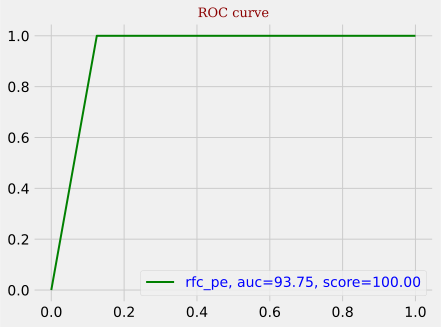

In [307]:
plot(train_labels, train_pred, "rfc_pe")

In [308]:
raw_feature_train = rfc_pe_model.predict(raw_feature_stacking_train_5).reshape(-1, 1)

In [309]:
with open("../models/rfc_pe_model.pkl", "wb") as f:
    pickle.dump(rfc_pe_model, f)
# with open("../models/xgb_pe_model.pkl", "wb") as f:
#     pickle.dump(rfc_pe_model, f)

 # train histogram

In [311]:
import os
import time
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [321]:
datapath = "../dataset/datacon_miner"
datapath = "../dataset/test"
black_path = []
black_list = []
for parent, dirnames, filenames in os.walk(datapath):
    if "/miner" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            black_path.append(fp)
            black_list.append(filename)
white_path = []
white_list = []
for parent, dirnames, filenames in os.walk(datapath):
    if "/not_miner" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            white_path.append(fp)
            white_list.append(filename)
            
print("Found {0} miner samples.".format(len(black_path)))
print("Found {0} not miner samples.".format(len(white_path)))

test_path = []
for parent, dirnames, filenames in os.walk(datapath):
    for filename in filenames:
        fp = os.path.join(parent, filename)
        test_path.append(fp)

hash_list = [os.path.split(sp)[-1] for sp in test_path]
test_fixed_path = [os.path.join("../tmp", sp) for sp in hash_list]

test_num = len(test_fixed_path)
print("Found {0} samples in total.".format(test_num))

with open("../models/hash_list.pkl", "wb") as f:
    pickle.dump(hash_list, f)

Found 10 miner samples.
Found 10 not miner samples.
Found 20 samples in total.


In [327]:
hisdatapath = "../histogram"
his_black_path = []
his_white_path = []
for parent, dirnames, filenames in os.walk(hisdatapath):
    for filename in filenames:
        fp = os.path.join(parent, filename)
        if filename[:-4] in black_list:
            his_black_path.append(fp)
        else:
            his_white_path.append(fp)

In [332]:
# 超参数
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
SEED = 4396

LENGTH = 512
WIDTH, HEIGHT = 32, 16
BATCH_SIZE = 16
EPOCH = 300
SHUFFLE = False
CLASSES = 2

LR = 1e-4

datapath = "../histogram"

raw_feature, raw_labels = [], []

with tqdm(total=20, ncols=80, desc="histogram") as pbar: # 11647
    for fp in his_black_path:
        with open(fp, 'r') as f:
            feature = f.readlines()
        feature = [float(his.strip()) for his in feature]
        raw_feature.append(feature)
        raw_labels.append(1)
        pbar.update(1)
    for fp in his_white_path:
        with open(fp, 'r') as f:
            feature = f.readlines()
        feature = [float(his.strip()) for his in feature]
        raw_feature.append(feature)
        raw_labels.append(0)
        pbar.update(1)

histogram: 100%|███████████████████████████████| 20/20 [00:00<00:00, 206.46it/s]


In [333]:
# 打乱顺序
np.random.seed(SEED)
tf.random.set_seed(SEED)

features, labels = np.array(raw_feature, dtype=np.float32), np.array(raw_labels, dtype=np.int32)

index = list(range(len(labels)))
np.random.shuffle(index)

features = features[index]
labels = labels[index] 

In [334]:
# 划分数据集
train_features, test_features, train_label, test_label = train_test_split(
    features,
    labels,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED)
train_features, valid_features, train_label, valid_label = train_test_split(
    train_features,
    train_label,
    test_size=VAL_SIZE,
    stratify=train_label,
    random_state=SEED)

In [335]:
# 加载dataset

train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_features, valid_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

2024-06-28 02:32:18.301297: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-06-28 02:32:18.327635: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 02:32:18.328274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4060 Laptop GPU computeCapability: 8.9
coreClock: 2.295GHz coreCount: 24 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.45GiB/s
2024-06-28 02:32:18.328879: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-06-28 02:32:18.333760: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not lo

In [336]:
# 模型

inputs = layers.Input(shape=(LENGTH, 1), dtype='float32')
re_inputs = tf.reshape(inputs, [-1, WIDTH, HEIGHT, 1])
Conv_1 = layers.Conv2D(60, (2, 2), padding='same', activation='relu')(re_inputs)
pool_1 = layers.MaxPooling2D()(Conv_1)
Conv_2 = layers.Conv2D(200, (2, 2), padding='same', activation='relu')(pool_1)
pool_2 = layers.MaxPooling2D()(Conv_2)
Flat = layers.Flatten()(pool_2)
Dense_1 = layers.Dense(500, activation='relu')(Flat)
dropout = layers.Dropout(0.2)(Dense_1)
# Dense_2 = layers.Dense(50, activation='relu')(dropout)
outputs = layers.Dense(1, activation='sigmoid')(Dense_1)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Nadam(LR),
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.fit(train_ds,
        validation_data=valid_ds,
        # class_weight=class_weight_dict,
        epochs=EPOCH,
        workers=4,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, min_delta=1e-4, mode='min'),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=0)])

predict = model.evaluate(test_ds)
print(predict)

model.save('../models/histogram_{0:.2f}.h5'.format(predict[1]), save_format="tf")


Epoch 1/300
1/1 [==============================] - 0s 87ms/step - loss: 0.6935 - accuracy: 0.3125 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/300
1/1 [==============================] - 0s 9ms/step - loss: 0.6922 - accuracy: 0.7500 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/300
1/1 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.8125 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 4/300
1/1 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.8125 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/300
1/1 [==============================] - 0s 10ms/step - loss: 0.6896 - accuracy: 0.8125 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/300
1/1 [==============================] - 0s 9ms/step - loss: 0.6889 - accuracy: 0.8750 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5000
[0.691649317741394, 0.5]
